<div style="background-color:white;" >
<div style="clear: both; display: table;">
  <div style="float: left; width: 14%; padding: 5px; height:auto">
    <img src="img/TUBraunschweig_CO_200vH_300dpi.jpg" alt="TU_Braunschweig" style="width:100%">
  </div>
  <div style="float: left; width: 28%; padding: 5px; height:auto">
    <img src="img/TU_Clausthal_Logo.png" alt="TU_Clausthal" style="width:100%">
  </div>
  <div style="float: left; width: 25%; padding: 5px; height:auto">
    <img src="img/ostfalia.jpg" alt="Ostfalia" style="width:100%">
  </div>
  <div style="float: left; width: 21%; padding: 5px;">
    <img src="img/niedersachsen_rgb_whitebg.png" alt="Niedersachsen" style="width:100%">
  </div>
  <div style="float: left; width: 9%; padding: 5px;">
    <img src="img/internet_BMBF_gefoerdert_2017_en.jpg" alt="bmbf" style="width:100%">
  </div>
</div>
<div style="text-align:center">
<img src="img/ki4all.jpg" alt="KI4ALL-Logo" width="200"/>
</div>
</div>

# Synthetic Biomedical Data – Lesson 3a: Irrelevant Features (Noise)

Part of the *Microcredit Biomedical Data Generator* learning module. We focus on *irrelevant features* (pure noise) and how they impact model training and evaluation.

➡️ [Back to Lesson 2b: Feature Distributions and Effect Size](02b_feature_distributions_effect_size.ipynb)
➡️ [Module Overview (README)](../README.md)

---

### Recap from Lesson 2
You:
- Generated synthetic datasets and checked **class balance**.
- Explored **scatterplots** and **feature distributions**.
- Quantified separation with **effect size** (Cohen’s d, Cliff’s delta).

Now we focus on **irrelevant features** — variables that add *no* useful information about the label.


### Why this lesson: Irrelevant features?
In real biomedical datasets, not all collected measurements are useful.
Some features carry **no information** about the outcome of interest.
These are called **irrelevant features** (or **noise features**).
If too many irrelevant features are present, they can:
- Make it harder to identify true biomarkers. Too many irrelevant features can hide the true signal.
- Increase model complexity and training time and make feature selection more difficult.
- Lead to overfitting if models start learning patterns in the noise.

- **Examples in practice**
  - A patient’s shoe size when predicting cancer outcome.
  - Random measurement fluctuations due to instrument sensitivity.
  - Biomarkers that are measured but unrelated to the studied disease. In high-dimensional biomarker screens, false discoveries are common without proper validation.

Synthetic data allows us to deliberately add irrelevant features to test how models and methods cope with them.

### What you'll learn
In this lesson, we will add irrelevant features to a synthetic dataset
and see how they appear in plots and effect size rankings. After completing this notebook, you will be able to:
- Generate an informative-only baseline dataset.
- Add purely irrelevant features with configurable distributions (normal, uniform, Laplace).
- Visualize how noise differs from informative features (e.g., pair plot / correlation heatmap).
- Compute and rank effect sizes (e.g., Cohen’s d) to identify likely signal carriers.
- Explain typical pitfalls with many irrelevant features and how to avoid them.

### Switch from `sklearn.make_classification` to `biomedical-data-generator`

In earlier notebooks we used `sklearn.make_classification` to synthesize data.
For this lesson onward we switch to the **biomedical-data-generator** because it gives us
didactic guarantees and metadata that are essential for teaching *feature roles* and
for running controlled benchmarks.

#### What was missing in `make_classification`
- **No explicit ground-truth roles** in the returned object (you can’t easily recover which
  columns are informative vs. redundant/repeated).
- **Limited control over noise** (mostly Gaussian) and no simple way to label “purely irrelevant”
  features as such.
- **Correlation modeling is coarse** (no block structures with a documented, reproducible pattern).
- **Teaching friction**: feature names are anonymous and vary across runs unless you manage
  additional bookkeeping.

#### What we gain with `biomedical-data-generator`
- **Explicit feature roles** and **indices** via `meta`:
  - `meta.informative_idx`, `meta.pseudo_idx`, `meta.noise_idx`
- **Clear decomposition of features** in `DatasetConfig`:
  - `n_informative`, `n_pseudo` (redundant/repeated-like), `n_noise` (purely irrelevant)
- **Controlled correlation structures** via `CorrCluster`:
  - e.g., `structure="toeplitz"` or `"equicorrelated"` with a target anchor role
- **Richer noise modeling**:
  - `noise_distribution` (e.g., `normal`, `uniform`, `laplace`) and `noise_scale`
- **Reproducibility & readability**:
  - `random_state` for deterministic generation
  - optional `feature_naming="prefixed"` → human-friendly names like `i1, i2, ..., p1, n1`
  - direct `DataFrame` return for tidy exploration

#### Concept mapping (old → new)
| `make_classification`            | `biomedical-data-generator`                     |
|----------------------------------|-------------------------------------------------|
| `n_samples`                      | `n_samples`                                     |
| `n_features`                     | `n_informative + n_noise`                       |
| `n_informative`                  | `n_informative`                                 |
| (no explicit “pure noise”)       | `n_noise`                                       |
| `class_sep`                      | `class_sep`                                     |
| `random_state`                   | `random_state`                                  |
| (no feature-role metadata)       | `meta.informative_idx / noise_idx` |

If needed, install  or upgrade the package `biomedical-data-generator`(uncomment in managed environments) via:
```python
%pip install -U biomedical-data-generator
```

### Code – Imports, Installation/Upgrade and quick sanity check

In [13]:
# If needed and running locally, uncomment and run this line once:
# %pip install -U biomedical-data-generator

# Data generator
from biomedical_data_generator import DatasetConfig, NoiseDistribution, CorrCluster
from biomedical_data_generator.generator import generate_dataset

# Core imports
import sys
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Print versions (sanity check)
print(f"Python: {sys.version.split()[0]}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")
import sklearn  # ensure the top-level module is imported before reading __version__
print(f"scikit-learn: {sklearn.__version__}")

# Plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 120)

# Reproducibility note:
# The generator is controlled via `random_state` in DatasetConfig (no global seeding required).


Python: 3.11.14
numpy: 2.3.3
pandas: 2.3.3
seaborn: 0.13.2
scikit-learn: 1.7.2


## Step 1 — Start with a clean dataset (no noise yet)

We begin with a *clean* baseline containing **only informative features**.
Then we **add purely irrelevant (noise) features** in controlled steps and **verify**
the ground truth via `meta`. This lets us demonstrate—without guesswork—how irrelevant
features impact models and validation.

### Why start clean?
- Isolates the true signal so any change after adding noise is attributable to the noise.
- Makes diagnostics predictable and reproducible.
- Provides a reference point for visualizations, metrics, and failure modes.

### What you’ll observe
- **Before vs. after noise:** how feature distributions and model performance shift.
- **Signal dilution:** accuracy/ROC may degrade when noise grows while the model capacity is fixed.
- **Robustness checks:** which learners and validations tolerate irrelevant features better.

### Ground-truth roles (used throughout this lesson)
- **Informative** → truly predictive features (start with 8 here).
- **Noise** → purely irrelevant features drawn from a chosen distribution.

> You can always inspect the roles via `meta`:
> `meta.informative_idx`, `meta.noise_idx`.

### Configuration for the baseline (now)
- Generator: `biomedical-data-generator`
- API: `DatasetConfig` → `generate_dataset`
- Counts: `n_informative=8`, `n_noise=0`
- Classes: `n_classes=2`, separability via `class_sep`
- Reproducibility: set `random_state`
- Convenience: `feature_naming="prefixed"` yields readable names (`i1, i2, …`)

We begin with **8 informative features** and no noise (8 informative, 0 noise). This forms the reference
to which we will add independent noise in controlled steps. Below create this baseline dataset using `DatasetConfig` + `generate_dataset`, returning a `DataFrame` and the `meta` object.

In [1]:
# Baseline configuration: only informative features (no pseudo, no noise)
informative_base_cfg = DatasetConfig(
    n_samples=30,
    n_informative=8,   # 8 informative features (matches the old baseline "8 base features")
    n_noise=0,
    n_classes=2,
    class_sep=1.2,     # keep consistent across the lesson
    feature_naming="prefixed",  # names like i1, i2, ...
    random_state=42,
)
X_informative_base, y_informative_base, meta_informative_base = generate_dataset(informative_base_cfg, return_dataframe=True)


,i1,corr1_2,corr1_3,corr1_4,corr1_5,corr1_6,i2,corr2_2,corr2_3,corr2_4,...,n11,n12,n13,n14,n15,n16,n17,n18,n19,n20
0,0.904717,-1.039984,0.750451,0.940565,-1.951035,-1.302180,-0.295283,-1.039984,0.750451,0.940565,...,1.620070,-0.182500,1.312025,0.973819,2.267644,1.808915,-0.091540,0.107534,-0.090192,0.323990
1,0.727840,-0.316243,-0.016801,-0.853044,0.879398,0.777792,-0.616801,-0.853044,0.879398,0.777792,...,0.363698,0.575547,-0.315174,0.008282,-1.030717,1.425329,-0.530822,0.215098,-0.902507,1.209265
2,0.666031,1.127241,0.467509,-0.859292,0.368751,-0.958883,-0.231249,-0.958883,0.878450,-0.049926,...,-0.218029,-1.409819,-1.934531,-0.203782,0.070419,-1.626084,2.214153,0.772540,-0.304973,1.571336
3,-0.752523,0.383394,0.999824,-1.058536,-0.125009,1.481456,0.823080,1.433215,0.091520,0.580777,...,1.193619,1.182531,-1.268014,-1.471115,-1.176200,0.724855,-0.451951,0.555146,1.229376,1.569998
4,1.478450,-0.049926,-0.184862,-0.680930,1.222541,-0.154529,-1.028328,-0.352134,0.532309,0.365444,...,-2.170615,-0.323985,-2.749676,0.503049,-0.777606,1.422106,-0.665878,0.044217,-0.805994,-0.998024


In [15]:
# Sanity checks: in the clean baseline we expect ONLY informative features
print("Informative features:", len(meta_informative_base.informative_idx))
print("Noise features     :", len(meta_informative_base.noise_idx))

assert len(meta_informative_base.informative_idx) == 8
assert len(meta_informative_base.noise_idx) == 0

Informative features: 8
Noise features     : 0


### About `DatasetMeta` and role checks

`generate_dataset` returns `X, y, meta`, where `meta` stores ground truth about feature roles:

- `meta.informative_idx` — integer indices of truly predictive features
- `meta.noise_idx` — indices of purely irrelevant features

The quick assertions help catch accidental drift (e.g., if defaults change or parameters are mistyped), keeping the lesson self-consistent.

In [16]:
print(f"X shape: {X_informative_base.shape}, y shape: {y_informative_base.shape}")

# Keep a single, consistent column for the class label
df_base = X_informative_base.copy()
df_base.insert(0, "class", y_informative_base)

display(df_base.head())


X shape: (30, 8), y shape: (30,)


,class,i1,i2,i3,i4,i5,i6,i7,i8
0,0,-0.295283,-1.639984,0.150451,0.340565,-2.551035,-1.902180,-0.472160,-0.916243
1,0,-0.616801,-1.453044,0.279398,0.177792,-0.533969,0.527241,-0.132491,-1.459292
2,0,-0.231249,-1.558883,0.278450,-0.649926,-0.784862,-1.280930,0.622541,-0.754529
3,0,-1.028328,-0.952134,-0.067691,-0.234556,-0.187267,-0.169179,1.541648,-1.006415
4,1,0.087757,-0.213773,1.215979,1.728972,0.486053,-0.240156,-0.224481,1.250593


### Explore class-conditional distributions (informative features only)

In this baseline, the dataset contains only informative features — no noise features — so any separation we observe should directly reflect the signal controlled by class_sep.

The figure plots the first six informative features as class-conditional histograms with KDE overlays:

We use density (not counts) and common_norm=False, so each class integrates to 1—overlaps and shifts are comparable even under class imbalance.

Clear mean shifts or reduced overlap indicate stronger separability; heavy overlap suggests single-feature rules will be error-prone.

KDE curves reveal distribution shape (uni/bimodality, skew) beyond binning artifacts.

Use these panels as a quick sanity check: increasing class_sep should produce cleaner separation; decreasing it should increase overlap.

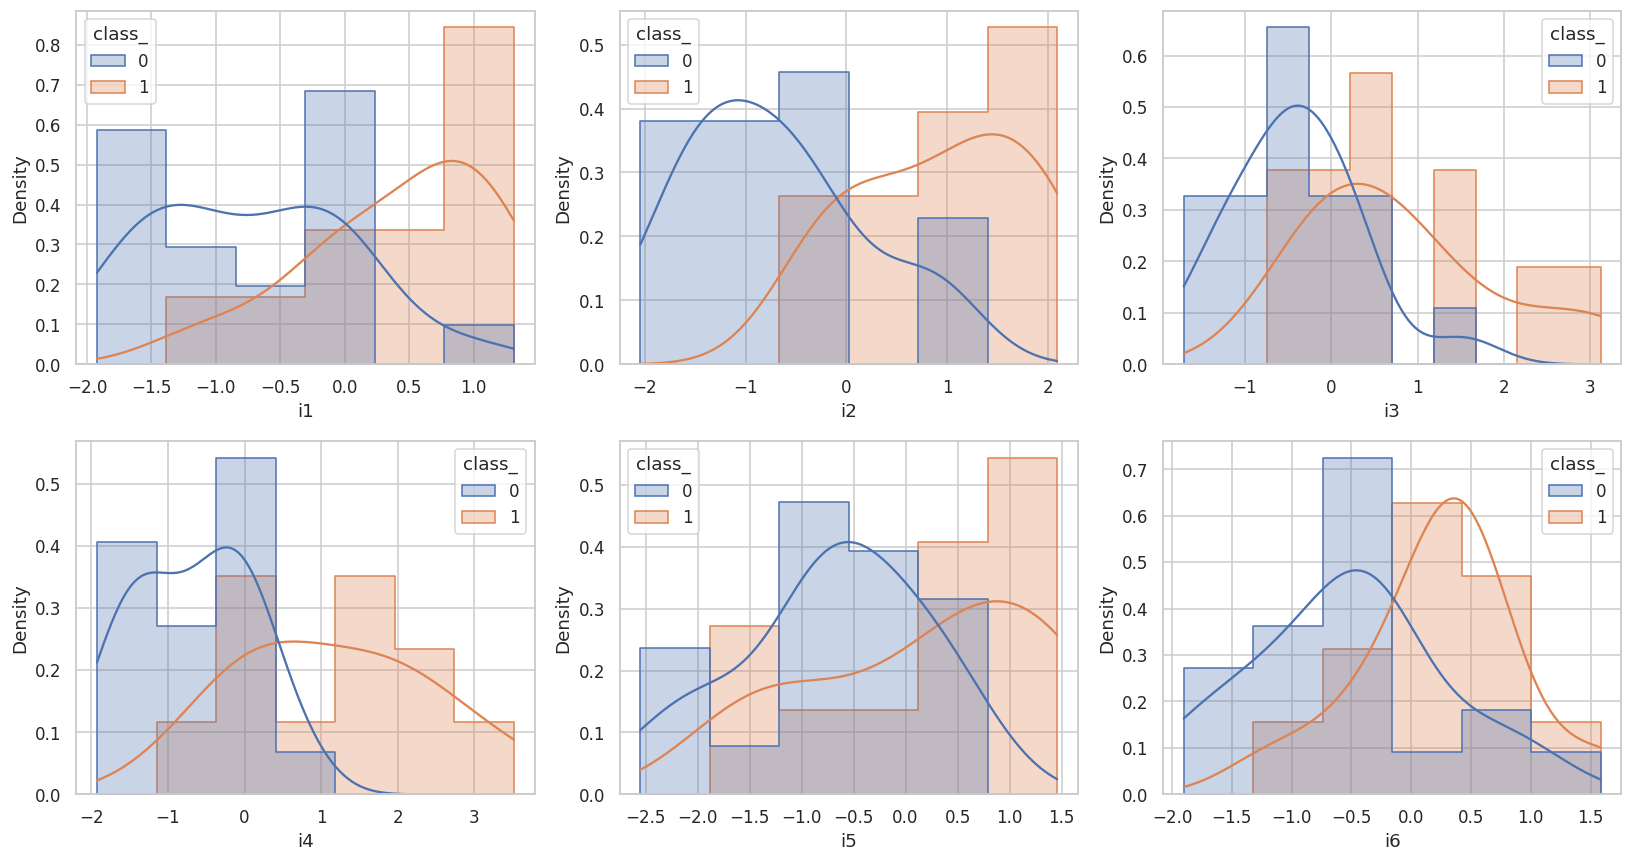

In [17]:
# Select the first 6 informative columns
informative_cols = [f"i{k}" for k in range(1, 7)]

# Combine features and class label
df_informative = df_base.copy()
df_informative.rename(columns={"class": "class_"}, inplace=True)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(informative_cols):
    ax = axes[i // 3, i % 3]
    sns.histplot(
        data=df_informative,
        x=col,
        hue="class_",
        stat="density",
        element="step",
        bins="auto",
        common_norm=False,
        alpha=0.3,
        kde=True,
        ax=ax
    )
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


### Check the effect size ranking

*Background on effect size and Cohen’s d and its interpretation is discussed in `feature_distributions_effect_size.ipynb`.*

In [18]:
# Effect size (Cohen's d) ranking for the informative baseline
def cohen_d(x1, x2):
    """Compute Cohen's d for two samples."""
    n1, n2 = len(x1), len(x2)
    mean1, mean2 = np.mean(x1), np.mean(x2)
    s1, s2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    # Pooled standard deviation
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    return (mean1 - mean2) / s_pooled if s_pooled > 0 else 0.0
# Compute Cohen's d for each feature
effect_sizes = {}
for col in X_informative_base.columns:
    d = cohen_d(X_informative_base[col][y_informative_base == 0],
                X_informative_base[col][y_informative_base == 1])
    effect_sizes[col] = abs(d)  # use absolute value for ranking
# Create a DataFrame for easy viewing
effect_size_df = pd.DataFrame.from_dict(effect_sizes, orient='index', columns=['Cohen_d']).sort_values(by='Cohen_d', ascending=False)
effect_size_df.index.name = 'Feature'
display(effect_size_df)

,Cohen_d
Feature,
i2,1.906762
i4,1.850142
i1,1.539019
i3,1.362386
i8,1.221927
i6,1.047238
i5,0.921378
i7,0.210969


## Step 2 — Add k irrelevant (noise) features

We now extend the baseline by adding **purely random (irrelevant) features**.
These features carry no signal about the label `y` and should be uncorrelated with the informative block.

We'll start with `n_noise = 12` noise features drawn from a **normal** distribution with unit scale.

We will now **add k purely random (irrelevant) features** by setting `n_noise > 0` and choosing a
`noise_distribution` (e.g., `normal`, `uniform`, or `laplace`).
We will then confirm the new ground-truth roles via `meta.noise_idx` and explore their distributions.

In [19]:
cfg_noise_normal = DatasetConfig(
    n_samples=30,
    n_informative=8,
    n_noise=12,               # add 12 pure-noise features
    n_classes=2,
    class_sep=1.2,            # keep consistent with the baseline
    feature_naming="prefixed",  # i1..i8, n1..n12
    noise_distribution=NoiseDistribution.normal,
    noise_scale=1.0,          # std for normal noise
    random_state=42,
)

Xn, yn, meta_n = generate_dataset(cfg_noise_normal, return_dataframe=True)
df_noise = Xn.copy()
df_noise.insert(0, "class", yn)

print(f"Xn shape: {Xn.shape}, yn shape: {yn.shape}")
Xn.head(3)


Xn shape: (30, 20), yn shape: (30,)


,i1,i2,i3,i4,i5,i6,i7,i8,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12
0,-0.295283,-1.639984,0.150451,0.340565,-2.551035,-1.902180,-0.472160,-0.916243,-0.876861,-0.721558,1.727350,1.511228,-0.152523,-2.310103,0.092127,-0.131138,0.223080,-1.560958,-1.686468,-1.448127
1,0.583199,-0.253044,1.479398,1.377792,0.666031,1.727241,1.067509,-0.259292,-0.094263,0.316494,-1.533861,0.637534,0.383394,0.054354,-0.837398,0.348776,1.433215,-0.297323,-0.826229,-0.067980
2,-0.231249,-1.558883,0.278450,-0.649926,-0.784862,-1.280930,0.622541,-0.754529,-1.757728,-0.097287,0.863828,-0.698930,0.999824,-0.471776,-0.594400,1.951013,0.091520,0.099477,0.247666,0.262036


### Why these generator settings?

- **`n_informative=8`** keeps the true signal fixed across all comparisons, so any change in model performance can be attributed to the amount/type of **noise** we add.
- **`feature_naming="prefixed"`** produces readable names:
  - `i1, i2, …` for informative features
  - `n1, n2, …` for noise features
  This matches the ground truth recorded in `meta`.
- **Noise semantics**:
  - `noise_distribution="normal"` uses `noise_scale` as **standard deviation**.
  - `noise_distribution="uniform"` uses `noise_scale` as **half-width** of the interval `[-scale, +scale]`.
  - `noise_distribution="laplace"` uses `noise_scale` as the **Laplace scale** (heavier tails).
- **Reproducibility**: `random_state=42` ensures identical datasets each time this cell is re-run.

In [20]:
# Check that we have 8 informative + 12 noise features
print("Informative features:", len(meta_n.informative_idx))
print("Noise features     :", len(meta_n.noise_idx))

assert len(meta_n.informative_idx) == 8
assert len(meta_n.noise_idx) == 12

# Show the first few informative and noise columns for a quick glance
cols_show = [f"i{k}" for k in range(1, 5)] + [f"n{k}" for k in range(1, 5)]
Xn[cols_show].head(5)

Informative features: 8
Noise features     : 12


,i1,i2,i3,i4,n1,n2,n3,n4
0,-0.295283,-1.639984,0.150451,0.340565,-0.876861,-0.721558,1.727350,1.511228
1,0.583199,-0.253044,1.479398,1.377792,-0.094263,0.316494,-1.533861,0.637534
2,-0.231249,-1.558883,0.278450,-0.649926,-1.757728,-0.097287,0.863828,-0.698930
3,-1.028328,-0.952134,-0.067691,-0.234556,-1.467045,2.093168,-0.328525,-1.013717
4,0.087757,-0.213773,1.215979,1.728972,2.129247,1.573355,-0.061324,0.032782


### What do noise features look like?
- **Definition:** Noise (irrelevant) features have **no relationship** to the class label.
- **Visual expectation:** Their class-conditional distributions should **overlap heavily**.
- We'll compare one **informative** feature with one **noise** feature.

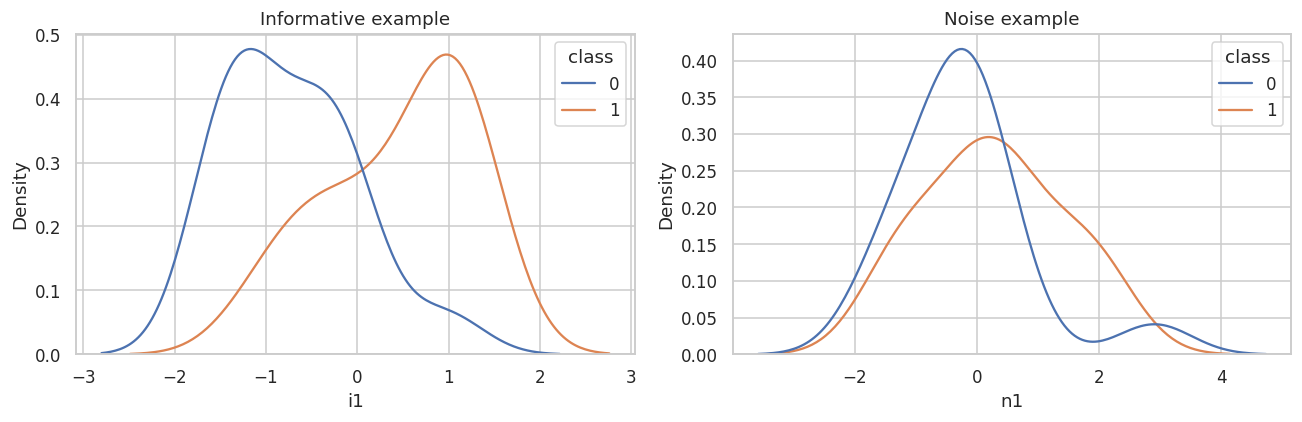

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.kdeplot(data=df_noise, x="i1", hue="class", common_norm=False)
plt.title("Informative example")

plt.subplot(1, 2, 2)
sns.kdeplot(data=df_noise, x="n1", hue="class", common_norm=False)
plt.title("Noise example")

plt.tight_layout()
plt.show()

### Check the effect size ranking again (with noise features now)
As visual impressions can be misleading. Let’s **quantify** class separation for the two features using **Cohen’s d**.
- Expect **larger d** for informative features.
- Expect **near 0** for noise features.

In [22]:
# Compute Cohen's d for each feature
effect_sizes = {}
for col in Xn.columns:
    d = cohen_d(Xn[col][yn == 0],
                Xn[col][yn == 1])
    effect_sizes[col] = abs(d)  # use absolute value for ranking
# Create a DataFrame for easy viewing
effect_size_df = pd.DataFrame.from_dict(effect_sizes, orient='index', columns=['Cohen_d']).sort_values(by='Cohen_d', ascending=False)
effect_size_df.index.name = 'Feature'
display(effect_size_df)

,Cohen_d
Feature,
i6,2.647796
i2,1.975808
i1,1.546507
i8,1.428769
i4,1.172879
i3,1.159425
n6,1.111837
i7,1.090829
n3,0.768536


#### Interpretation — Effect size ranking (now over **all** features)

This cell computes **Cohen’s d** for each standardized feature in `Xn` (class labels in `yn`) and ranks features by the **absolute** effect size.
Because `Xn` is standardized, (d) is the difference in class means measured in pooled standard deviations.

**How to read the table**

* Larger (|d|) ⇒ stronger univariate class separation. Ranking by |d| should list informative features near the top and noise features near the bottom. The top rows are the most discriminative features.
> **Check:** Do `i*` columns dominate the top? Are `n*` near the bottom?
* With **noise features** included, most should cluster near (|d|\approx 0). Occasional larger (|d|) among noise can appear by chance—especially with small (n) or large (p).

**Good practice / caveats**

* Use this as **screening only**; confirm choices with **nested CV** on a held-out set to avoid leakage.
* Control multiplicity (e.g., **Benjamini–Hochberg FDR**) or compare against a **permutation-based null** for (|d|).
* The common 0.2/0.5/0.8 “small/medium/large” rules of thumb are **not reliable** in high-dimensional biomarker settings—prefer data-driven thresholds.
* Correlated features can share high (|d|); consider redundancy checks or multivariate models after screening.

**Try this:**
- Increase the number of noise features to 100: Does the top-10 list still capture informative features?

### Inspect distributions (normal noise)

With `noise_distribution="normal"` and `noise_scale=1.0`, we expect:
- Approximately zero mean and unit variance for noise columns.
- No visible class separation in the noise columns.
- Similar spread across noise columns, up to sampling variability.


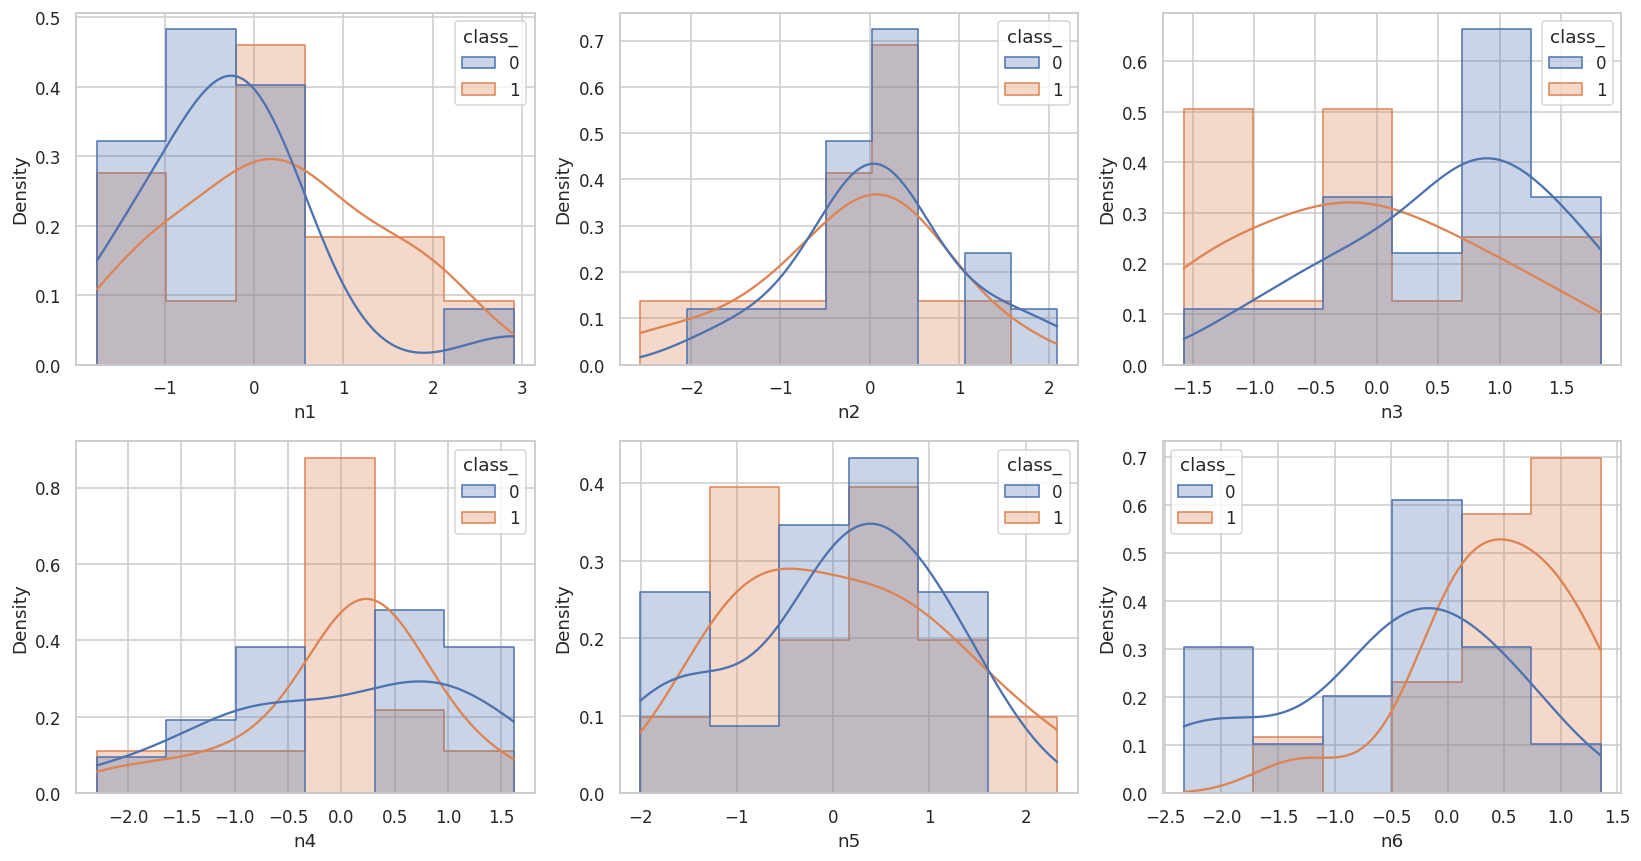

In [23]:
import matplotlib.pyplot as plt

noise_cols = [f"n{k}" for k in range(1, 7)]

# Color by class
# Combine features and class label
df_noise = Xn.copy()
df_noise["class_"] = yn


fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(noise_cols):
    ax = axes[i // 3, i % 3]
    sns.histplot(
        data=df_noise,
        x=col,
        hue="class_",
        stat="density",
        element="step",
        bins="auto",
        common_norm=False,
        alpha=0.3,
        kde=True,
        ax=ax
    )
    # ax.set_title(f"{col} by class")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

### How to read the histograms

- **Informative features (`i*`)** will often show **class-conditional shifts** (or different spreads), hinting at separability.
- **Noise features (`n*`)** should look class-agnostic: the overlaid distributions for the two classes (if visualized) should nearly coincide.
- With **small `n_samples`**, sampling variation is expected—don’t over-interpret minor bumps or slight mean shifts in a single run. If you want a more stable view, increase `n_samples` in `cfg_noise_normal` or average over multiple runs.

## Step 3 — Uniform noise

Now we switch to `noise_distribution="uniform"`.
Here, `noise_scale` acts as the **half-width** of the interval, i.e. values are roughly in `[-scale, +scale]`.

We’ll use `noise_scale=2.0`, so noise features should mostly lie in `[-2, 2]` with a flat-ish density.

In [24]:
cfg_noise_uniform = DatasetConfig(
    n_samples=30,
    n_informative=8,
    n_noise=12,
    n_classes=2,
    class_sep=1.2,            # consistent
    feature_naming="prefixed",
    noise_distribution=NoiseDistribution.uniform,
    noise_scale=2.0,          # half-width for uniform
    random_state=42,
)

Xu, yu, meta_u = generate_dataset(cfg_noise_uniform, return_dataframe=True)

print(f"Xu shape: {Xu.shape}, yu shape: {yu.shape}")
print("Noise columns (first 5):", [f"n{k}" for k in range(1, 6)])

# Empirical min/max of first 5 noise columns to verify ~[-2, 2]
mins = Xu[[f"n{k}" for k in range(1, 6)]].min().round(3)
maxs = Xu[[f"n{k}" for k in range(1, 6)]].max().round(3)
display(pd.DataFrame({"min": mins, "max": maxs}))

Xu shape: (30, 20), yu shape: (30,)
Noise columns (first 5): ['n1', 'n2', 'n3', 'n4', 'n5']


,min,max
n1,-1.915,1.684
n2,-1.826,1.918
n3,-1.620,1.795
n4,-1.662,1.836
n5,-1.951,1.947


### Uniform noise expectations

With `noise_distribution="uniform"` and `noise_scale=2.0`, values are roughly in **`[-2, 2]`**.
You should observe:
- Empirical **min/max** close to −2 and +2 (but not equal—finite samples fall short of true bounds).
- **Nearly constant density** within the interval, unlike the bell shape of normal noise.

After changing the noise distribution to `"uniform"` is there any difference in the ranking of cohen's d?

### Sanity check: correlations

Irrelevant features should be **uncorrelated** with `y` (up to sampling noise) and show no systematic correlation with informative features.

We’ll compute:
- Absolute correlation between each **noise** feature and the **label** `y`.
- Maximum absolute correlation between **noise** and **informative** features.


In [25]:
# Work on the uniform-noise dataset (Xu, yu, meta_u)
informative_columns = [f"i{k}" for k in range(1, len(meta_u.informative_idx)+1)]
noise_columns = [f"n{k}" for k in range(1, len(meta_u.noise_idx)+1)]

# Correlation of noise with the label (point-biserial via pandas corr with numeric y)
yu_numeric = pd.Series(yu, name="y").astype(float)

noise_y_corr = (
    Xu[noise_columns].apply(lambda s: s.corr(yu_numeric)).abs().sort_values(ascending=False)
)
print("Top 5 |abs(corr(noise, y))| (should be modest due to randomness):")
display(noise_y_corr.head(5).round(3))

# Max |corr| between noise and any informative feature
corr_matrix = Xu[informative_columns + noise_columns].corr().abs()
max_noise_inf = corr_matrix.loc[informative_columns, noise_columns].max().sort_values(ascending=False)
print("Top 5 max |corr| between informative and noise (should be modest):")
display(max_noise_inf.head(5).round(3))

Top 5 |abs(corr(noise, y))| (should be modest due to randomness):


n2     0.266
n11    0.212
n6     0.187
n12    0.171
n5     0.155
dtype: float64

Top 5 max |corr| between informative and noise (should be modest):


n5     0.410
n7     0.376
n4     0.323
n8     0.300
n11    0.287
dtype: float64

### Spurious correlations grow with dimensionality

Even if each noise feature is uninformative, the **largest absolute correlation** among many noise variables can be non-trivial **by chance**.

Rule of thumb (for intuition): the maximum spurious correlation scales roughly like
$$
\max_j \lvert r_{j,y}\rvert \sim \sqrt{\tfrac{2\log p}{n}}
$$
where \(p\) is the number of features and \(n\) the sample size.


➡️ As you add more noise features or reduce sample size, **chance correlations** become more prominent.


## Step 4 — Increase number of noise features + cross-validated model performance

We now study how *increasing the number of irrelevant (noise) features* affects model performance feature selection stability and false discoveries. We measure how a simple linear classifier (Logistic Regression) behaves under **Stratified 5-Fold CV** as we increase the number of noise features.


**Plan**
1. Keep the true signal fixed: 8 informative features, same effect size/separability.
2. Vary the number of **pure noise** features: e.g. `k ∈ {0, 50, 200, 1000}`.
3. Train a simple linear classifier (Logistic Regression) **with scaling** and evaluate via **Stratified 5-Fold CV**. We keep the model fixed to isolate the effect of dimensionality.
4. Only one factor changes: the number of irrelevant features.
5. Track:
   - **Balanced accuracy** (robust to small class imbalances)
   - **Feature discovery** quality via a simple univariate ranking (precision@k; false discoveries among top-k)

> Note: For stability, we use `n_samples=120` for this sweep (a bit larger than the earlier 30). We keep this fixed to isolate the effect of dimensionality.

In [26]:
# Experiment configuration

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score, make_scorer

# Fixed signal & CV settings
SEED = 42
N_SAMPLES = 120
N_INFORMATIVE = 8
CLASS_SEP = 1.2

# Noise counts to sweep over
NOISE_COUNTS = [0, 50, 200, 1000]

# Estimator: scale -> logistic regression (binary)
# liblinear is robust for small-sample, L2 by default
ESTIMATOR = make_pipeline(
    RobustScaler(),
    LogisticRegression(solver="liblinear", random_state=SEED, max_iter=2000)
)

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
SCORER = make_scorer(balanced_accuracy_score)

### Why logistic regression + scaling?

- **Logistic Regression** is a transparent linear baseline; with L2 regularization it copes reasonably with moderate noise.
- **RobustScaler** avoids feature-scale dominance and reduces optimization issues. Robust scaling (median + IQR) is less sensitive to outliers than standard scaling (mean + std).
- The pipeline ensures **no data leakage**: scaling parameters are learned **inside** each CV fold.
- Alternatives to try later:
  - **Linear SVM** (hinge loss) for a similar linear margin-based view.
  - **Elastic Net** for embedded sparsity (tuning needed).
  - **Tree ensembles** (e.g. Random Forests) for non-linear baselines.


In [27]:
# Dataset factory (using biomedical-data-generator)
def make_dataset(n_noise: int,
                 noise_dist: NoiseDistribution = NoiseDistribution.normal,
                 noise_scale: float = 1.0,
                 *,
                 n_samples: int = N_SAMPLES,
                 n_informative: int = N_INFORMATIVE,
                 class_sep: float = CLASS_SEP,
                 seed: int = SEED):
    """
    Build a dataset with a fixed informative block and variable number of pure-noise features.
    Returns: (X_df, y_np, meta)
    """
    cfg1 = DatasetConfig(
        n_samples=n_samples,
        n_informative=n_informative,
        n_noise=n_noise,
        n_classes=2,
        class_sep=class_sep,
        feature_naming="prefixed",      # i1..iK, n1..nK
        noise_distribution=noise_dist,  # "normal" | "uniform" | "laplace"
        noise_scale=noise_scale,
        random_state=seed,
    )
    X_df, y_np, meta_data = generate_dataset(cfg1, return_dataframe=True)
    return X_df, y_np, meta_data


### Guarding against leakage in CV

By wrapping preprocessing and the estimator in a **single pipeline** and passing it to `cross_val_score`, we guarantee that:
- **Scaling** and **model fitting** occur **only on the training folds**.
- The held-out fold remains unseen until scoring, yielding **honest** performance estimates.


In [28]:
# CV evaluation helper
def evaluate_cv(X_df: pd.DataFrame, y_np: np.ndarray,
                estimator=ESTIMATOR,
                cv=CV,
                scorer=SCORER) -> tuple[float, float]:
    """
    Returns (mean_bal_acc, std_bal_acc) from K-fold CV.
    """
    scores = cross_val_score(estimator, X_df, y_np, cv=cv, scoring=scorer, n_jobs=None)
    return float(scores.mean()), float(scores.std())

### On the feature discovery metric

We use a **univariate ranking** (|corr| with `y`) to keep things simple and fast:

- Reports **precision@k** with \(k=\) number of truly informative features.
- Counts **false discoveries in top-k** (noise among the top-ranked features).

**Limitations**:
- Ignores **feature interactions** and **correlation structure**.
- Sensitive to **outliers** and **class imbalance**.

Later extensions could use permutation importance, or embedded coefficients with **nested CV** for fair model-based selection.


In [29]:
# Simple feature discovery metric (precision@k and false discoveries)
def precision_at_k_by_abs_corr(X_df: pd.DataFrame, y_np: np.ndarray, meta_data, k: int | None = None) -> dict:
    """
    Rank features by absolute Pearson correlation with y (point-biserial for binary y).
    Compute precision@k where k defaults to the number of informative features.
    Also report the number of noise features in top-k (false discoveries).
    """
    y_series = pd.Series(y_np, name="y").astype(float)
    # absolute correlation with y (skip non-finite if any)
    abs_corr = X_df.apply(lambda s: s.corr(y_series)).abs().sort_values(ascending=False)

    if k is None:
        k = len(meta_data.informative_idx)

    topk = list(abs_corr.index[:k])

    # Map ground truth: indices -> column names, using this dataset's columns
    informative_columns_list = list(X_df.columns.take(meta_data.informative_idx))
    noise_columns_list = list(X_df.columns.take(meta_data.noise_idx))

    tp = sum(col in informative_columns_list for col in topk)
    fp = sum(col in noise_columns_list for col in topk)  # false discoveries among top-k
    prec = tp / k if k > 0 else float("nan"

)

    return {
        "k": k,
        "precision_at_k": prec,
        "false_discoveries_topk": fp,
        "tp_topk": tp,
    }


### Run the sweep over noise counts, collecting balanced accuracy and feature discovery metrics

In [30]:
def run_sweep(noise_counts, noise_dist, noise_scale) -> pd.DataFrame:
    results = []
    for k_noise in noise_counts:
        Xk, yk, meta_k = make_dataset(n_noise=k_noise, noise_dist=noise_dist, noise_scale=noise_scale)
        mean_ba, std_ba = evaluate_cv(Xk, yk)
        disc = precision_at_k_by_abs_corr(Xk, yk, meta_k, k=len(meta_k.informative_idx))
        results.append({
            "dist": str(noise_dist),
            "scale": noise_scale,
            "n_noise": k_noise,
            "n_informative": len(meta_k.informative_idx),
            "bal_acc_mean": mean_ba,
            "bal_acc_std": std_ba,
            "precision_at_k": disc["precision_at_k"],
            "false_discoveries_topk": disc["false_discoveries_topk"],
            "tp_topk": disc["tp_topk"],
        })
    return pd.DataFrame(results).sort_values("n_noise").reset_index(drop=True)

result_df = run_sweep(NOISE_COUNTS, NoiseDistribution.normal, 1.0)

### What trends to expect

- **Balanced accuracy** typically **decreases** as `n_noise` increases (harder signal recovery).
- **Precision@k** falls with more noise—top-k becomes increasingly contaminated by chance hits.
- **False discoveries** in top-k grow with dimensionality, even for honest univariate filters.

### Plot results

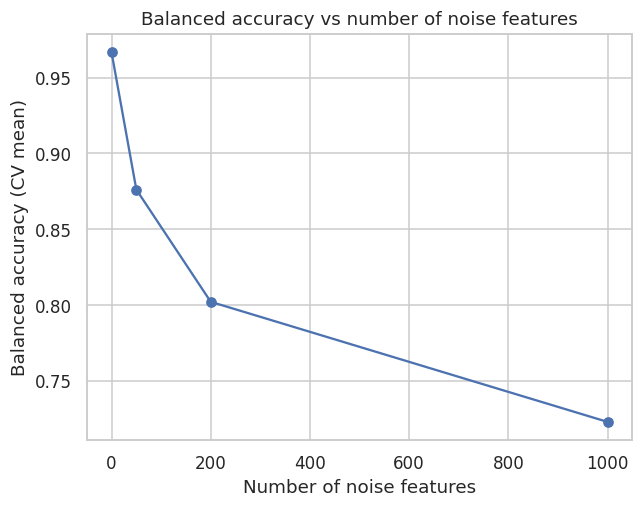

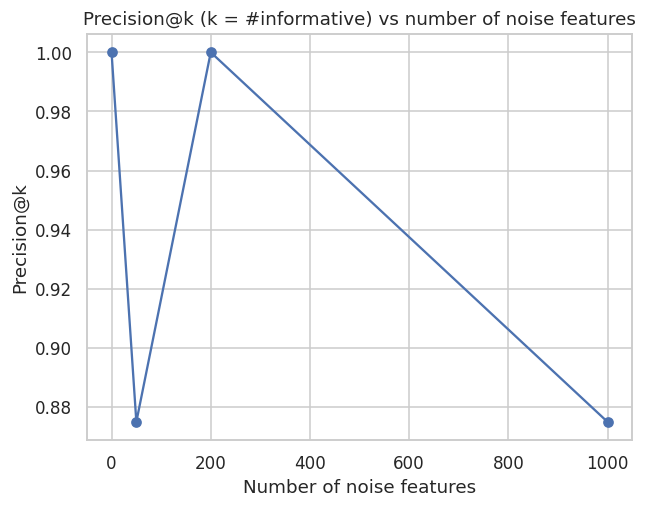

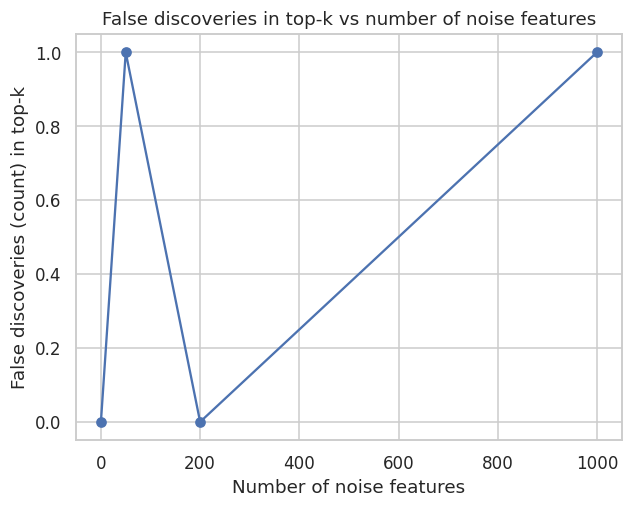

In [31]:
import matplotlib.pyplot as plt

# Balanced accuracy vs number of noise features
plt.figure()
plt.plot(result_df["n_noise"], result_df["bal_acc_mean"], marker="o")
plt.title("Balanced accuracy vs number of noise features")
plt.xlabel("Number of noise features")
plt.ylabel("Balanced accuracy (CV mean)")
plt.show()

# Precision@k vs number of noise features
plt.figure()
plt.plot(result_df["n_noise"], result_df["precision_at_k"], marker="o")
plt.title("Precision@k (k = #informative) vs number of noise features")
plt.xlabel("Number of noise features")
plt.ylabel("Precision@k")
plt.show()

# False discoveries among top-k vs number of noise features
plt.figure()
plt.plot(result_df["n_noise"], result_df["false_discoveries_topk"], marker="o")
plt.title("False discoveries in top-k vs number of noise features")
plt.xlabel("Number of noise features")
plt.ylabel("False discoveries (count) in top-k")
plt.show()


### Reading the plots carefully

- Expect **non-monotonic fluctuations** due to finite-sample randomness—don’t over-fit to a single curve.
- Look for the **overall slope**: does performance degrade roughly as dimensionality rises?
- If a method looks unusually stable, verify you are **not leaking information** and that regularization is properly tuned.

### Computational notes

- This sweep is lightweight (single model, 5-fold CV).
- As you add methods (e.g., nested CV, repeated subsampling, multiple models), runtime will grow quickly.
- Keep random seeds fixed for **comparability**, and cache intermediate results when exploring many settings.


### Interpretation checklist

- **Performance drop**: As `n_noise` grows, balanced accuracy should typically **decrease** unless regularization and sample size are strong.
- **Ranking dilution**: Simple univariate rankings (abs corr) become **less precise** as dimensionality grows; expect **lower precision@k** and **more false discoveries**.
- **Sample size matters**: With fixed effect size, increasing `n_samples` generally improves both performance and discovery metrics.
- **Regularization**: Linear models with proper regularization can resist some noise, but the *curse of dimensionality* still applies.


### Biomedical context: why this matters

Omics datasets (e.g., gene expression, proteomics, methylation) often have **p ≫ n**:
- Thousands of features with **few dozens of samples**.
- Many features are unrelated to the phenotype—i.e., **irrelevant** for prediction.

Understanding how irrelevant features affect **generalization** and **feature discovery** helps you:
- Choose appropriate **regularization** and **model families**,
- Design **feature selection** protocols that avoid false discoveries,
- Plan for **validation** on independent cohorts.


## Step 5 — Comparing noise distributions

Repeat the sweep with:
- `noise_distribution="uniform", noise_scale=2.0` (values roughly in `[-2, 2]`)
- `noise_distribution="laplace", noise_scale=1.0` (heavier tails)

Then compare curves (balanced accuracy, precision@k) across distributions.

In [32]:
df_uniform = run_sweep(NOISE_COUNTS, NoiseDistribution.uniform, 2.0)
df_laplace = run_sweep(NOISE_COUNTS, NoiseDistribution.laplace, 1.0)
display(df_uniform, df_laplace)

,dist,scale,n_noise,n_informative,bal_acc_mean,bal_acc_std,precision_at_k,false_discoveries_topk,tp_topk
0,NoiseDistribution.uniform,2.0,0,8,0.966667,0.040825,1.000,0,8
1,NoiseDistribution.uniform,2.0,50,8,0.900408,0.019694,1.000,0,8
2,NoiseDistribution.uniform,2.0,200,8,0.866434,0.056252,0.875,1,7
3,NoiseDistribution.uniform,2.0,1000,8,0.767243,0.104285,1.000,0,8


,dist,scale,n_noise,n_informative,bal_acc_mean,bal_acc_std,precision_at_k,false_discoveries_topk,tp_topk
0,NoiseDistribution.laplace,1.0,0,8,0.966667,0.040825,1.000,0,8
1,NoiseDistribution.laplace,1.0,50,8,0.843473,0.072560,1.000,0,8
2,NoiseDistribution.laplace,1.0,200,8,0.711072,0.040196,0.875,1,7
3,NoiseDistribution.laplace,1.0,1000,8,0.633726,0.092437,1.000,0,8


### Comparing noise distributions

- **Uniform** noise (bounded support) usually yields tighter extremes than normal at small `n`, reducing outlier risks.
- **Laplace** noise (heavier tails) increases the chance of **extreme values**, which can inflate spurious correlations and destabilize rankings.
- When sweeping distributions, keep **`n_samples`, `n_informative`, and `class_sep`** fixed to isolate the distributional effect.


In [33]:
# Optional: quick train/test split on the normal-noise dataset to see if noise hurts performance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_tr, X_te, y_tr, y_te = train_test_split(Xn.values, yn, test_size=0.3, random_state=42, stratify=yn)

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, random_state=42))
clf.fit(X_tr, y_tr)
pred = clf.predict(X_te)
print("Logistic Regression accuracy (normal noise, 12 feats):", round(accuracy_score(y_te, pred), 3))


Logistic Regression accuracy (normal noise, 12 feats): 1.0


### Reflection

Take a moment to connect the code results with the concepts:

- **Visual inspection**:
  - Did the noise features look different from the informative ones in the histograms/KDE plots?
  - Could you spot noise features by eye alone?

- **Effect size**:
  - Did the calculated Cohen’s d values match your visual impression?
  - Were the informative features ranked higher than the noise features?

- **Model performance** (if you ran the optional classifier):
  - How much did adding noise affect classification accuracy?
  - What might happen if you add *hundreds* of noise features?

**Think ahead**:
In real biomedical studies, many measured variables are irrelevant.
Why is it important to detect and filter them before applying complex models?

## Exercises

1. **Add random noise features**
   - Extend your dataset with 5–10 new columns of purely random numbers
     (e.g., `np.random.normal`).
   - **Observation goal:** Do the class distributions change?
   - **Why this matters:** In real-world data, irrelevant measurements are
     always present. Models must learn to ignore them.

2. **Increase the number of irrelevant features**
   - Add 100 random features instead of 5.
   - Train a simple classifier.
   - **Observation goal:** Does performance change? Does training take longer?
   - **Why this matters:** More noise makes feature selection harder and
     increases the risk of overfitting.

> **Takeaway:**
> Irrelevant features dilute the signal. Synthetic data allows us to
> control how much noise exists, so we can test how methods behave in
> high-noise vs. low-noise scenarios.

## Quick Takeaway (3a)
- Rule of thumb: Expect some noise features to rank high purely by chance.
- **Irrelevant features** add no predictive value and can **dilute** signal.
- Visually, noise features show **strong overlap** between classes.
- **Effect size** (e.g., Cohen’s d) helps **quantify** which features are informative.
- In high-noise settings, feature selection (see MC XXX) becomes crucial.

## Next Steps

In **Lesson 3b: Correlated Features**, you will:
- Simulate features that **move together** (e.g., biological pathways).
- Visualize correlation structures (heatmaps, pairplots).
- See how **redundancy** complicates analysis.

➡️ Continue with: **[`03b_correlated_features.ipynb`](03b_correlated_features.ipynb)`**
